<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3245180 entries, 0 to 3245179
Data columns (total 8 columns):
 #   Column            Dtype  
---  ------            -----  
 0   Time              float64
 1   Source            object 
 2   Destination       object 
 3   Protocol          object 
 4   Length            int64  
 5   Source Port       float64
 6   Destination Port  float64
 7   bad_packet        int64  
dtypes: float64(3), int64(2), object(3)
memory usage: 198.1+ MB
Missing Values:
Time                      0
Source                    0
Destination               0
Protocol                  0
Length                    0
Source Port         3241718
Destination Port    3241718
bad_packet                0
dtype: int64

Malicious Packet Distribution:
bad_packet
1    3240656
0       4524
Name: count, dtype: int64


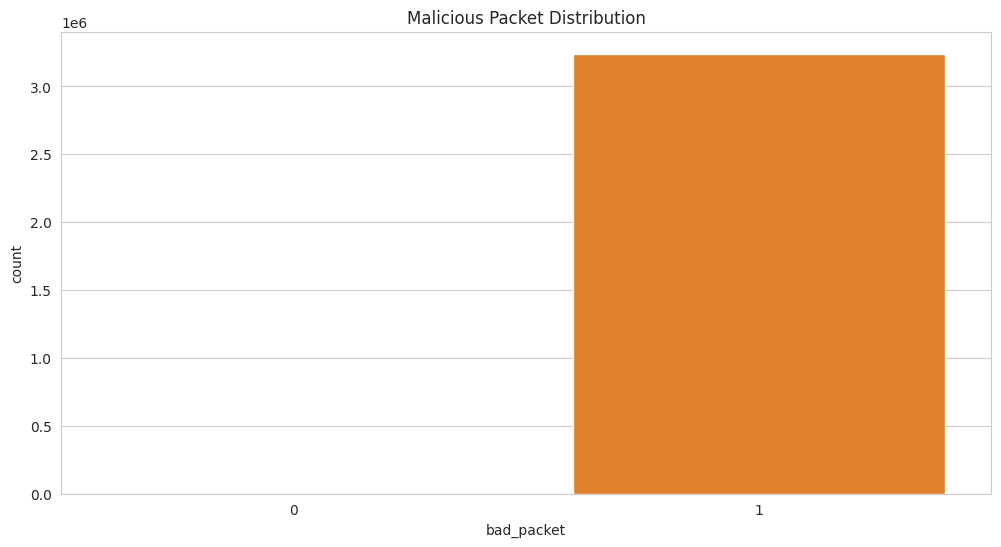


Handling missing port values:
Initial missing Source Port: 3241718
Initial missing Destination Port: 3241718

Initial shape: (3245180, 8)
After removing duplicates: (3245180, 10)


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


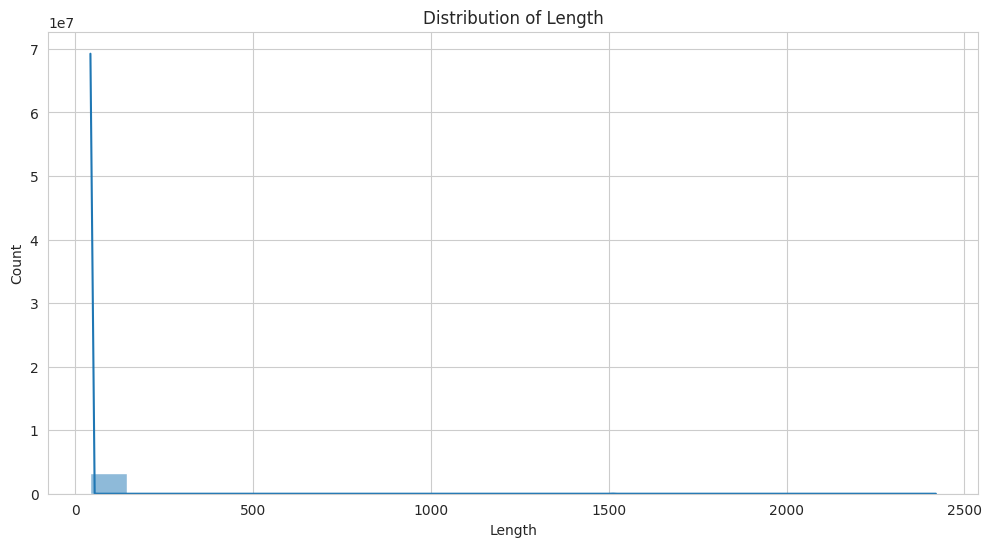

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


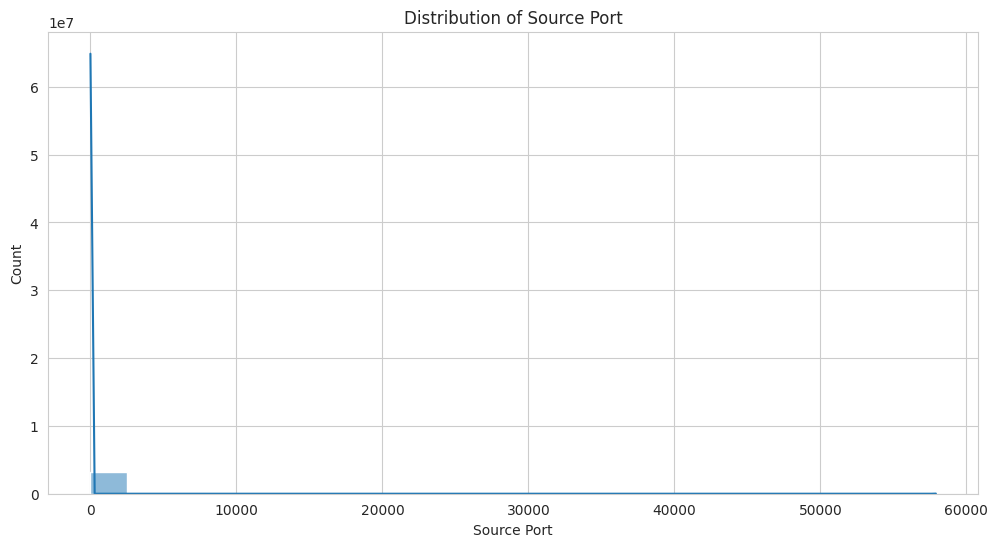

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


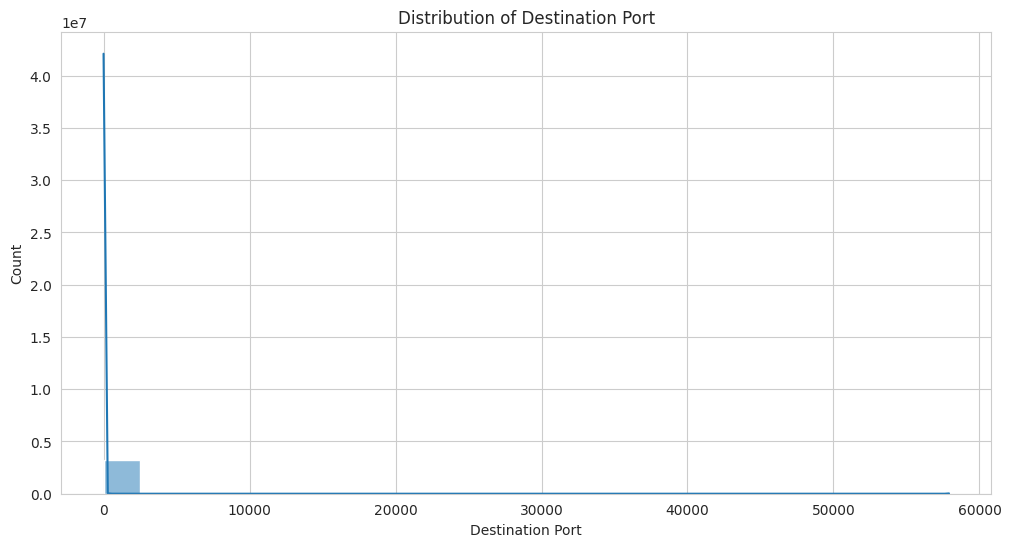

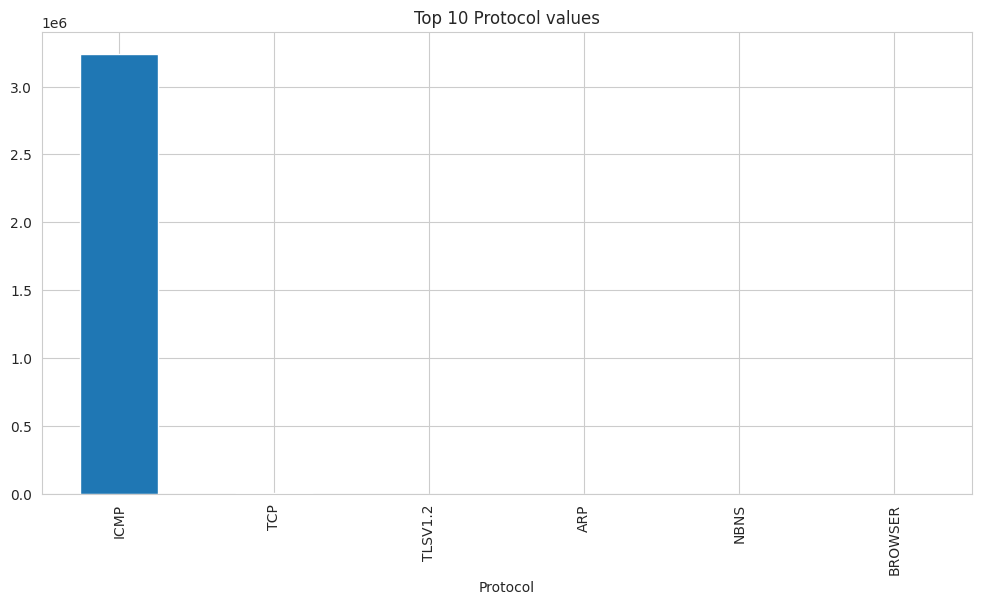

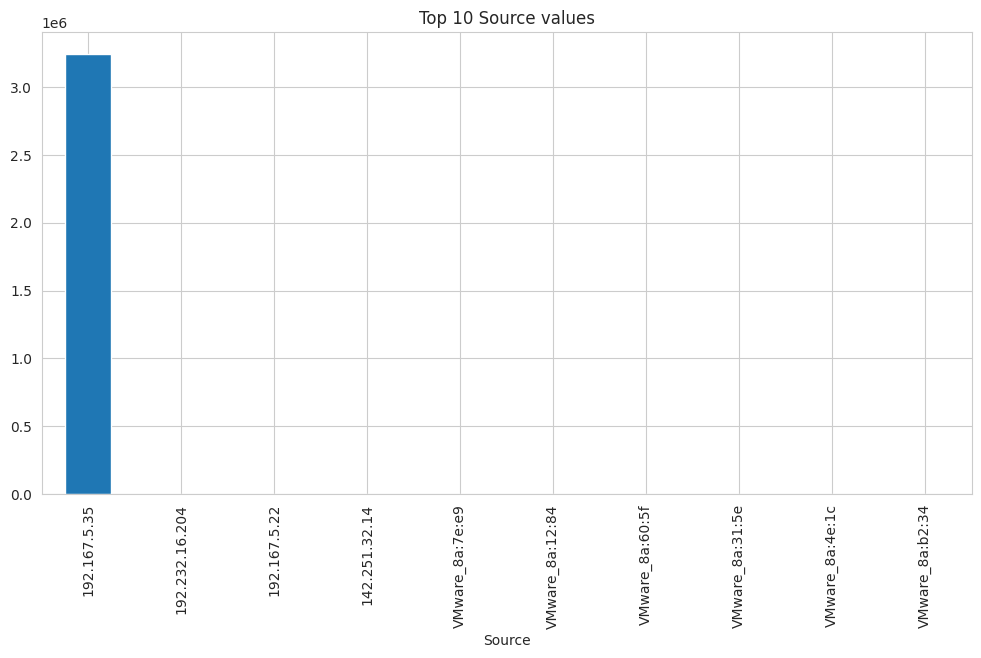

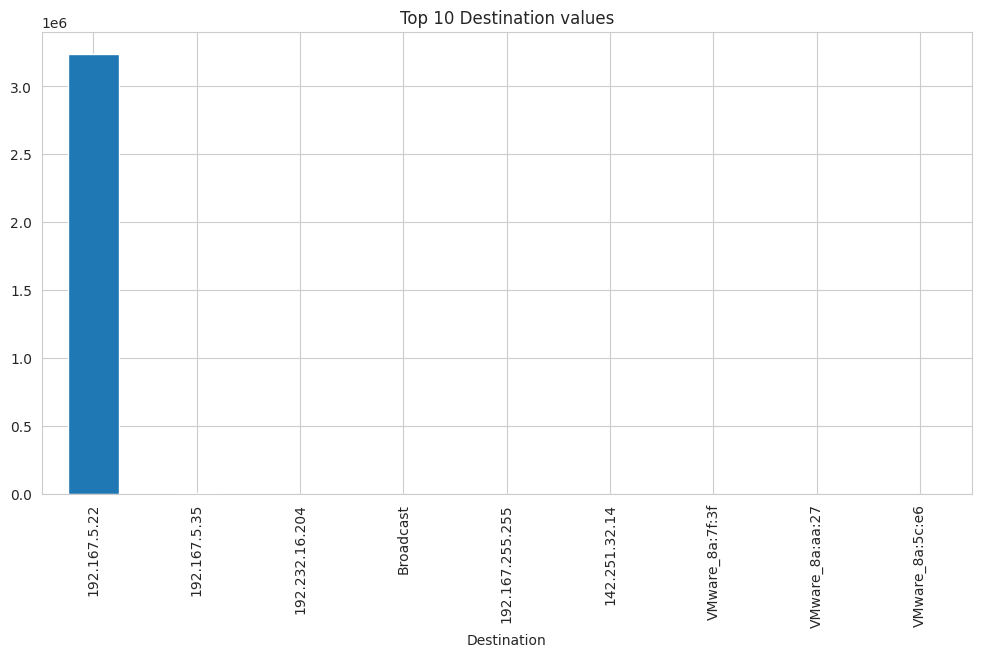

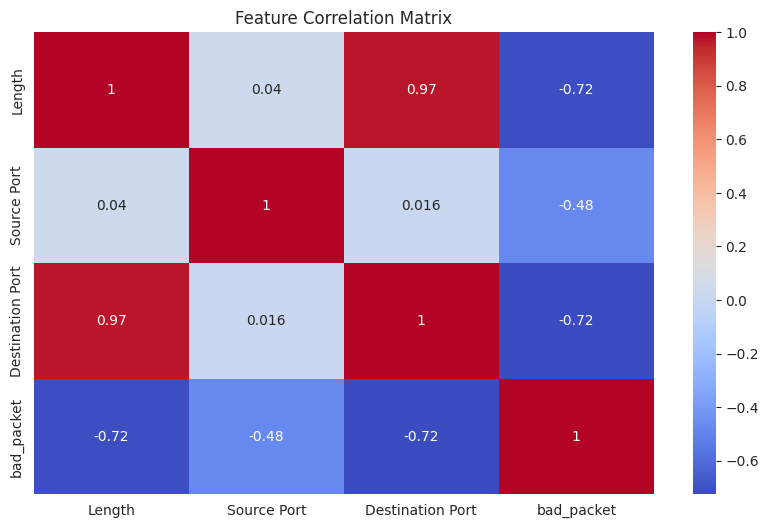

Processing complete. Cleaned dataset saved as 'processed_network_traffic.csv'


In [19]:
# %% [markdown]
# # Network Traffic Data Analysis & Feature Extraction
# 
# **Dataset**: NandakumarMenonAdvait_MT_S2.csv (Malicious Activity Detection)

# %% [markdown]
# ## 1. Import Required Libraries

# %%
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder

# %%
# Set visualization style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

# %% [markdown]
# ## 2. Load Dataset

# %%
# Load the dataset
df = pd.read_csv('/kaggle/input/network-traffic-data-malicious-activity-detection/NandakumarMenonAdvait_MT_S2.csv')

# %% [markdown]
# ## 3. Initial Data Exploration

# %%
# Display first 5 rows
df.head()

# %%
# Get dataset information
df.info()

# %%
# Statistical summary
df.describe(include='all').T

# %%
# Check for missing values
print("Missing Values:")
print(df.isnull().sum())

# %%
# Check class distribution for bad_packet
print("\nMalicious Packet Distribution:")
print(df['bad_packet'].value_counts())
sns.countplot(x='bad_packet', data=df)
plt.title('Malicious Packet Distribution')
plt.show()

# %% [markdown]
# ## 4. Data Cleaning

# %%
# Handle missing values in port columns
print("\nHandling missing port values:")
print(f"Initial missing Source Port: {df['Source Port'].isnull().sum()}")
print(f"Initial missing Destination Port: {df['Destination Port'].isnull().sum()}")

# Fill missing ports with -1 (indicating missing)
df_clean = df.copy()
df_clean['Source Port'] = df_clean['Source Port'].fillna(-1)
df_clean['Destination Port'] = df_clean['Destination Port'].fillna(-1)

# Convert ports to integers
df_clean['Source Port'] = df_clean['Source Port'].astype(int)
df_clean['Destination Port'] = df_clean['Destination Port'].astype(int)

# %%
# Convert Time to datetime (assuming UNIX timestamp)
df_clean['Time'] = pd.to_datetime(df_clean['Time'], unit='s')
df_clean['hour'] = df_clean['Time'].dt.hour
df_clean['day_of_week'] = df_clean['Time'].dt.dayofweek

# %%
# Clean protocol names
df_clean['Protocol'] = df_clean['Protocol'].str.upper().str.strip()

# %%
# Remove duplicates
print(f"\nInitial shape: {df.shape}")
df_clean = df_clean.drop_duplicates()
print(f"After removing duplicates: {df_clean.shape}")

# %% [markdown]
# ## 5. Exploratory Data Analysis (EDA)

# %%
# Numerical features distribution
numerical_features = ['Length', 'Source Port', 'Destination Port']
for col in numerical_features:
    plt.figure()
    sns.histplot(df_clean[col], kde=True)
    plt.title(f'Distribution of {col}')
    plt.show()

# %%
# Categorical features analysis
categorical_features = ['Protocol', 'Source', 'Destination']
for col in categorical_features:
    plt.figure()
    df_clean[col].value_counts().head(10).plot(kind='bar')
    plt.title(f'Top 10 {col} values')
    plt.show()

# %%
# Correlation matrix
plt.figure(figsize=(10, 6))
sns.heatmap(df_clean[['Length', 'Source Port', 'Destination Port', 'bad_packet']].corr(), 
            annot=True, cmap='coolwarm')
plt.title('Feature Correlation Matrix')
plt.show()

# %% [markdown]
# ## 6. Feature Extraction

# %%
# Feature Engineering

# 1. Protocol encoding
protocol_encoder = LabelEncoder()
df_clean['Protocol_encoded'] = protocol_encoder.fit_transform(df_clean['Protocol'])

# 2. Port-based features
df_clean['is_common_source_port'] = df_clean['Source Port'].isin([80, 443, 22, 53]).astype(int)
df_clean['is_common_dest_port'] = df_clean['Destination Port'].isin([80, 443, 22, 53]).astype(int)

# 3. Packet length features
df_clean['Length_log'] = np.log1p(df_clean['Length'])
df_clean['large_packet_flag'] = (df_clean['Length'] > 1500).astype(int)

# 4. Frequency encoding for IP addresses
for col in ['Source', 'Destination']:
    freq_encoder = df_clean[col].value_counts(normalize=True)
    df_clean[f'{col}_freq'] = df_clean[col].map(freq_encoder)

# 5. Time-based features
df_clean['is_business_hours'] = df_clean['hour'].between(9, 17).astype(int)
df_clean['is_weekend'] = (df_clean['day_of_week'] >= 5).astype(int)

# 6. Interaction features
df_clean['port_diff'] = df_clean['Destination Port'] - df_clean['Source Port']
df_clean['port_sum'] = df_clean['Destination Port'] + df_clean['Source Port']

# %% [markdown]
# ## 7. Save Processed Data

# %%
# Save cleaned and feature-engineered dataset
df_clean.to_csv('processed_network_traffic.csv', index=False)

print("Processing complete. Cleaned dataset saved as 'processed_network_traffic.csv'")

In [20]:
# Network Traffic Analysis - Text Output Version
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder

# Load data
df = pd.read_csv('/kaggle/input/network-traffic-data-malicious-activity-detection/NandakumarMenonAdvait_MT_S2.csv')

# Initial Exploration
print("=== Initial Data Exploration ===")
print(f"Total entries: {len(df):,}")
print("\nData Types:")
print(df.dtypes)
print("\nMissing Values:")
print(df.isnull().sum())

# Data Cleaning
df_clean = df.copy()
df_clean['Source Port'] = df_clean['Source Port'].fillna(-1).astype(int)
df_clean['Destination Port'] = df_clean['Destination Port'].fillna(-1).astype(int)
df_clean['Time'] = pd.to_datetime(df_clean['Time'], unit='s')
df_clean['Protocol'] = df_clean['Protocol'].str.upper().str.strip()
df_clean = df_clean.drop_duplicates()

print("\n=== Cleaning Results ===")
print(f"Remaining entries after deduplication: {len(df_clean):,}")
print(f"Missing ports after cleaning: SRC={df_clean['Source Port'].eq(-1).sum():,} DST={df_clean['Destination Port'].eq(-1).sum():,}")

# Basic Stats
print("\n=== Basic Statistics ===")
print("Packet Length:")
print(df_clean['Length'].describe(percentiles=[.25,.5,.75,.9,.99]))
print("\nCommon Ports:")
print(f"Top Source Ports:\n{df_clean['Source Port'].value_counts().head(5)}")
print(f"\nTop Destination Ports:\n{df_clean['Destination Port'].value_counts().head(5)}")
print("\nProtocol Distribution:")
print(df_clean['Protocol'].value_counts().head(5))

# Feature Engineering
print("\n=== Feature Engineering ===")
protocol_encoder = LabelEncoder()
df_clean['Protocol_encoded'] = protocol_encoder.fit_transform(df_clean['Protocol'])

# Port features
common_ports = [80, 443, 22, 53]
df_clean['common_src_port'] = df_clean['Source Port'].isin(common_ports).astype(int)
df_clean['common_dst_port'] = df_clean['Destination Port'].isin(common_ports).astype(int)
print(f"Common port coverage: SRC={df_clean['common_src_port'].mean():.2%} DST={df_clean['common_dst_port'].mean():.2%}")

# Time features
df_clean['hour'] = df_clean['Time'].dt.hour
df_clean['is_business_hours'] = df_clean['hour'].between(9, 17).astype(int)
print(f"Business hours traffic: {df_clean['is_business_hours'].mean():.2%}")

# IP frequency encoding
for ip_col in ['Source', 'Destination']:
    freq = df_clean[ip_col].value_counts(normalize=True)
    df_clean[f'{ip_col}_freq'] = df_clean[ip_col].map(freq)
print("\nIP Frequency Stats:")
print(f"Source IP frequency - Mean: {df_clean['Source_freq'].mean():.4f} Max: {df_clean['Source_freq'].max():.4f}")
print(f"Destination IP frequency - Mean: {df_clean['Destination_freq'].mean():.4f} Max: {df_clean['Destination_freq'].max():.4f}")

# Correlation Analysis
print("\n=== Correlation with Target ===")
corr_matrix = df_clean[['Length', 'Source Port', 'Destination Port', 'bad_packet']].corr()
print(corr_matrix['bad_packet'].sort_values(ascending=False))

# Final Output
print("\n=== Processing Complete ===")
print(f"Final dataset shape: {df_clean.shape}")
print("New features added:", [col for col in df_clean.columns if col not in df.columns])

=== Initial Data Exploration ===
Total entries: 3,245,180

Data Types:
Time                float64
Source               object
Destination          object
Protocol             object
Length                int64
Source Port         float64
Destination Port    float64
bad_packet            int64
dtype: object

Missing Values:
Time                      0
Source                    0
Destination               0
Protocol                  0
Length                    0
Source Port         3241718
Destination Port    3241718
bad_packet                0
dtype: int64

=== Cleaning Results ===
Remaining entries after deduplication: 3,245,180
Missing ports after cleaning: SRC=3,241,718 DST=3,241,718

=== Basic Statistics ===
Packet Length:
count    3.245180e+06
mean     4.303799e+01
std      3.871504e+01
min      4.200000e+01
25%      4.200000e+01
50%      4.200000e+01
75%      4.200000e+01
90%      4.200000e+01
99%      4.200000e+01
max      2.420000e+03
Name: Length, dtype: float64

Common Ports:

In [21]:
# %% [markdown]
# ## 6. Unified Packet-Level Feature Extraction

# %%
import numpy as np
import pandas as pd

# Start from df_clean, which has:
# ['Time','Source','Destination','Protocol','Length','Source Port','Destination Port','bad_packet']

# 1) Build a new DataFrame with exactly your 10 features + label:
df_unified = pd.DataFrame({
    'proto'         : df_clean['Protocol'].str.lower(),    # protocol as string
    'service'       : 'unknown',                           # placeholder service
    'duration'      : 0.0,                                 # single packet → zero
    'orig_bytes'    : df_clean['Length'],
    'resp_bytes'    : 0,
    'conn_state'    : 'SF',                                # assumed state
    'orig_pkts'     : 1,
    'orig_ip_bytes' : df_clean['Length'],
    'resp_pkts'     : 0,
    'resp_ip_bytes' : 0,
    'label'         : df_clean['bad_packet'].astype(int)
})

# 2) (Optional) Preview and types
print(df_unified.head())
print("Unified feature dtypes:\n", df_unified.dtypes)

# 3) Save for downstream usage
df_unified.to_csv('network_traffic_unified.csv', index=False)
print("Unified schema saved with columns:", df_unified.columns.tolist())


  proto  service  duration  orig_bytes  resp_bytes conn_state  orig_pkts  \
0   arp  unknown       0.0          60           0         SF          1   
1   arp  unknown       0.0          60           0         SF          1   
2   arp  unknown       0.0          60           0         SF          1   
3   arp  unknown       0.0          60           0         SF          1   
4   arp  unknown       0.0          60           0         SF          1   

   orig_ip_bytes  resp_pkts  resp_ip_bytes  label  
0             60          0              0      0  
1             60          0              0      0  
2             60          0              0      0  
3             60          0              0      0  
4             60          0              0      0  
Unified feature dtypes:
 proto             object
service           object
duration         float64
orig_bytes         int64
resp_bytes         int64
conn_state        object
orig_pkts          int64
orig_ip_bytes      int64
resp_p

In [22]:
preprocessor = pipeline.named_steps['preprocessor']
cat_enc = preprocessor.named_transformers_['cat']
print("Categorical feature encoder classes:")
for i, feat in enumerate(['proto', 'service', 'conn_state']):
    print(f" - {feat}: {cat_enc.categories_[i]}")


Categorical feature encoder classes:
 - proto: ['arp' 'browser' 'icmp' 'nbns' 'tcp' 'tlsv1.2']
 - service: ['unknown']
 - conn_state: ['SF']


In [23]:
# Verify timestamp conversion
print(df_clean[['Time','hour']].head(2))

# Check label-protocol relationship
print(pd.crosstab(df_clean['Protocol'], df_clean['bad_packet']))

# Validate IP frequency calculation
source_freq_sample = df_clean.groupby('Source')['Source_freq'].first().describe()
print(f"\nSource Frequency Validation:\n{source_freq_sample}") 

                           Time  hour
0 1970-01-01 00:00:00.000000000     0
1 1970-01-01 00:00:00.081233458     0
bad_packet     0        1
Protocol                 
ARP          241        0
BROWSER       47        0
ICMP         821  3240656
NBNS          53        0
TCP         2974        0
TLSV1.2      388        0

Source Frequency Validation:
count    2.900000e+01
mean     3.448276e-02
std      1.854885e-01
min      6.162986e-07
25%      1.848896e-06
50%      2.773344e-06
75%      1.078523e-05
max      9.989246e-01
Name: Source_freq, dtype: float64


Cross-Validation ROC-AUC: 1.0000 (±0.0000)

Test Set Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1139
           1       1.00      1.00      1.00    972197

    accuracy                           1.00    973336
   macro avg       1.00      1.00      1.00    973336
weighted avg       1.00      1.00      1.00    973336


Confusion Matrix:
[[  1139      0]
 [     0 972197]]

Test ROC-AUC: 1.0000


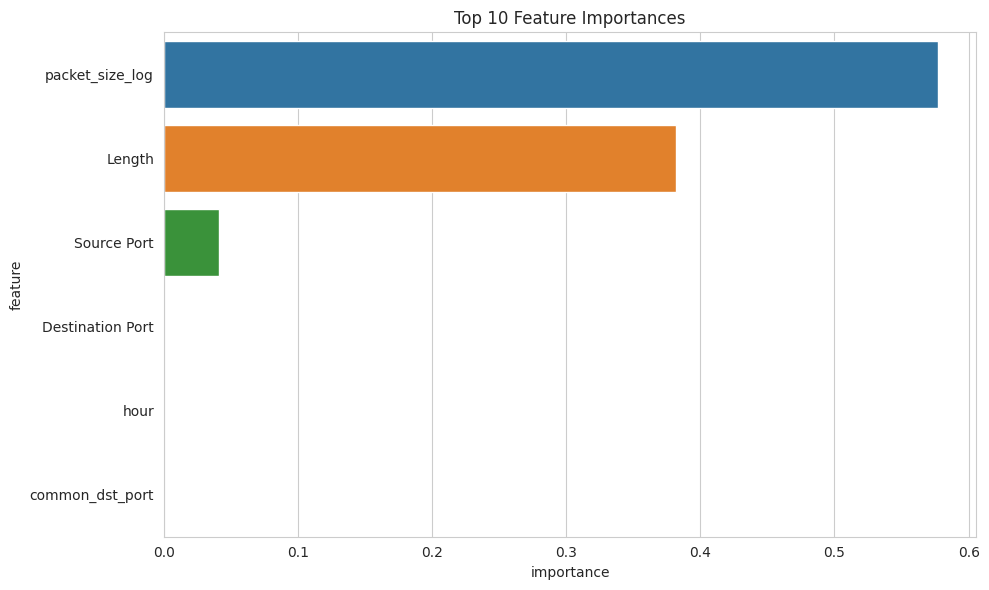

In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from xgboost import XGBClassifier

# Kaggle-friendly settings
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)
pd.options.mode.chained_assignment = None  # Disable SettingWithCopyWarning

# Load data
df = pd.read_csv('/kaggle/input/network-traffic-data-malicious-activity-detection/NandakumarMenonAdvait_MT_S2.csv')

# Clean and filter data
def preprocess_data(df):
    # Create clean copy
    df = df.copy()
    
    # Handle missing ports
    df['Source Port'] = df['Source Port'].fillna(-1).astype(int)
    df['Destination Port'] = df['Destination Port'].fillna(-1).astype(int)
    
    # Filter protocols
    df = df[df['Protocol'].str.upper().isin(['ICMP', 'TCP'])]
    
    # Basic time features
    df['Time'] = pd.to_datetime(df['Time'], unit='s')
    df['hour'] = df['Time'].dt.hour
    
    # Safe features
    df['packet_size_log'] = np.log1p(df['Length'])
    df['common_dst_port'] = df['Destination Port'].isin([80, 443, 22, 3389]).astype(int)
    
    return df.drop(['Time', 'Source', 'Destination', 'Protocol'], axis=1)

# Preprocess
processed_df = preprocess_data(df)
X = processed_df.drop('bad_packet', axis=1)
y = processed_df['bad_packet']

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.3, 
    random_state=42, 
    stratify=y
)

# Handle class imbalance using XGBoost parameters
scale_ratio = y_train.value_counts()[0] / y_train.value_counts()[1]

# Configure model
model = XGBClassifier(
    n_estimators=150,
    learning_rate=0.1,
    max_depth=3,
    subsample=0.8,
    colsample_bytree=0.8,
    scale_pos_weight=scale_ratio,
    random_state=42,
    use_label_encoder=False,
    eval_metric='logloss'
)

# Cross-validation
cv = StratifiedKFold(n_splits=3)
cv_scores = []

for train_idx, val_idx in cv.split(X_train, y_train):
    X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
    y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]
    
    model.fit(X_tr, y_tr)
    preds = model.predict_proba(X_val)[:, 1]
    cv_scores.append(roc_auc_score(y_val, preds))

print(f"Cross-Validation ROC-AUC: {np.mean(cv_scores):.4f} (±{np.std(cv_scores):.4f})")

# Final training
model.fit(X_train, y_train)

# Evaluation
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]

print("\nTest Set Classification Report:")
print(classification_report(y_test, y_pred))

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print(f"\nTest ROC-AUC: {roc_auc_score(y_test, y_prob):.4f}")

# Feature Importance
fi = pd.DataFrame({
    'feature': X.columns,
    'importance': model.feature_importances_
}).sort_values('importance', ascending=False).head(10)

plt.figure(figsize=(10, 6))
sns.barplot(x='importance', y='feature', data=fi)
plt.title('Top 10 Feature Importances')
plt.tight_layout()
plt.show()

In [25]:
# %% [markdown]
# ## 8. Train XGBoost on Unified Features

# %%
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.metrics import accuracy_score
from xgboost import XGBClassifier
import joblib

# Define features in fixed order for inference compatibility
FEATURE_ORDER = [
    'proto', 'service', 'duration',
    'orig_bytes', 'resp_bytes', 'conn_state',
    'orig_pkts', 'orig_ip_bytes',
    'resp_pkts', 'resp_ip_bytes'
]

target = 'label'

# 1) Drop NA and slice out features + label
df_train = df_unified[FEATURE_ORDER + [target]].dropna()
X = df_train[FEATURE_ORDER]
y = df_train[target]

print("Feature column data types:\n", X.dtypes)
print("Label distribution:\n", y.value_counts())

# 2) Check if both classes exist for binary classification
if len(np.unique(y)) < 2:
    print(" Not enough class variation to train a binary classifier (need both 0 and 1).")
else:
    # 3) Train/test split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )

    # 4) Define preprocessing
    categorical_features = ['proto', 'service', 'conn_state']
    numerical_features = [f for f in FEATURE_ORDER if f not in categorical_features]

    preprocessor = ColumnTransformer([
        ("cat", OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1), categorical_features),
        ("num", StandardScaler(), numerical_features)
    ])

    # 5) Build pipeline
    pipeline = Pipeline([
        ("preprocessor", preprocessor),
        ("classifier", XGBClassifier(
            use_label_encoder=False,
            eval_metric='logloss',
            random_state=42
        ))
    ])

    # 6) Train model
    pipeline.fit(X_train, y_train)

    # 7) Save pipeline
    joblib.dump(pipeline, "model_5_pipeline.pkl")

    # 8) Evaluate
    y_pred = pipeline.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print(" Unified-model test accuracy:", accuracy)


Feature column data types:
 proto             object
service           object
duration         float64
orig_bytes         int64
resp_bytes         int64
conn_state        object
orig_pkts          int64
orig_ip_bytes      int64
resp_pkts          int64
resp_ip_bytes      int64
dtype: object
Label distribution:
 label
1    3240656
0       4524
Name: count, dtype: int64
 Unified-model test accuracy: 1.0


In [26]:
# Clean environment setup
!pip install scikit-learn==1.0.2 xgboost==1.5.1 pandas==1.3.5 numpy==1.21.6

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from xgboost import XGBClassifier
from collections import Counter

# Set visualization style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

def load_and_clean():
    print("Loading and cleaning data...")
    df = pd.read_csv('/kaggle/input/network-traffic-data-malicious-activity-detection/NandakumarMenonAdvait_MT_S2.csv')
    
    # Create clean copy properly
    df_clean = df.copy()
    df_clean['Source Port'] = df_clean['Source Port'].fillna(-1).astype(int)
    df_clean['Destination Port'] = df_clean['Destination Port'].fillna(-1).astype(int)
    df_clean['Time'] = pd.to_datetime(df_clean['Time'], unit='s')
    df_clean['Protocol'] = df_clean['Protocol'].str.upper().str.strip()
    return df_clean

def filter_protocols(df):
    print("\nFiltering protocols...")
    protocols = ['ICMP', 'TCP']
    return df[df['Protocol'].isin(protocols)].copy()  # Explicit copy

def create_features(df):
    print("\nCreating safe features...")
    df = df.copy()  # Prevent chained assignment
    df['hour'] = df['Time'].dt.hour
    df['Protocol_encoded'] = df['Protocol'].astype('category').cat.codes
    df['Length_log'] = np.log1p(df['Length'])
    return df.drop(['Time', 'Source', 'Destination', 'Protocol'], axis=1)

def main():
    # Data pipeline
    df = load_and_clean()
    df_filtered = filter_protocols(df)
    processed_data = create_features(df_filtered)
    
    # Split data
    X = processed_data.drop('bad_packet', axis=1)
    y = processed_data['bad_packet']
    
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, random_state=42, stratify=y
    )
    
    # Handle imbalance using scale_pos_weight
    ratio = np.sum(y_train == 0) / np.sum(y_train == 1)
    model = XGBClassifier(
        n_estimators=100,
        learning_rate=0.1,
        max_depth=3,
        subsample=0.8,
        colsample_bytree=0.8,
        scale_pos_weight=ratio,
        random_state=42,
        use_label_encoder=False,
        eval_metric='logloss'
    )
    
    # Cross-validation
    cv = StratifiedKFold(n_splits=5)
    cv_scores = []
    for train_idx, val_idx in cv.split(X_train, y_train):
        X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
        y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]
        
        model.fit(X_tr, y_tr)
        preds = model.predict_proba(X_val)[:, 1]
        cv_scores.append(roc_auc_score(y_val, preds))
    
    print(f"Cross-val ROC-AUC: {np.mean(cv_scores):.4f} (±{np.std(cv_scores):.4f})")
    
    # Final evaluation
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1]
    
    print("\nTest Classification Report:")
    print(classification_report(y_test, y_pred))
    
    print(f"Test ROC-AUC: {roc_auc_score(y_test, y_prob):.4f}")

if __name__ == "__main__":
    main()

  Using cached scikit-learn-1.0.2.tar.gz (6.7 MB)
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  error: subprocess-exited-with-error
  
  × Preparing metadata (pyproject.toml) did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (pyproject.toml) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.
Loading and cleaning data...

Filtering protocols...

Creating safe features...
Cross-val ROC-AUC: 1.0000 (±0.0000)

Test Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1139
           1       1.00      1.00      1.00    972197

    accuracy                           1.00    9733

In [27]:
import joblib

# Load the saved pipeline
pipeline_loaded = joblib.load("model_5_pipeline.pkl")

# Use it to predict
y_pred = pipeline_loaded.predict(X_test)

# Check accuracy again
from sklearn.metrics import accuracy_score
print("Reloaded model accuracy:", accuracy_score(y_test, y_pred))

Reloaded model accuracy: 1.0
